![logo](LogoLine_horizon_C3S.png)

# Barrean mask for SPI/SPEI

This notebook is a collection of recipes for calculating the Barrean mask for SPI/SPE6 used in the ["Copernicus Interactive Climate Atlas: gridded monthly dataset"](https://cds.climate.copernicus.eu/datasets/multi-origin-c3s-atlas?tab=overview). It illustrates the entire process, including data access, calculation and visualization.

Note that this notebook is intended for reproducibility purposes and is not yet well organized or fully documented.

A bare-earth (barrean) mask is necessary for Standardized Precipitation Index (SPI) and Standardized Precipitation Evapotranspiration Index (SPEI) calculations to ensure meaningful results in arid or non-vegetated regions

The C3S team masks SPI/SPEI data based on the following criteria: 
- Any pixel with less than 50% land (lsm < 0.5),
- No high or low vegetation (tvl = 0, tvh = 0) 
- Snow depth larger than 10m (sd >= 10)
- Annual mean precipitation for 1991–2020 is less than 0.3 mm day-1 (a maximum number of months without precipitation can be consederer instead of the mean precipitation)

In ERA5, low and high vegetation from ERA5 are static (no monthly values), just snow depth varies throughout the year. If I am not mistaken, 10m snow depth is the maximum and all areas with the maximum value do not change snow depths during the year — thus, all snow depths of 10m are indicative of glaciers. For the static data, the stream should not matter, and you can use the monthly mean (moda) or the operational one (oper).

The only non-static data is precipitation. For the C3S bulletins, they use an annual mean of P=0.3 mm day-1 during 1991–2020. I am currently trying to see if it makes sense to introduce this criterion too for the drought indices. At least for ERA5-Drought it may not be needed, as the affected regions are largely captured by the P0 in the SPI calculation and are set to NaN by default. I do not know how you handle those regions/months without precipitation though. 

**<span style="color:red">Please be advised that downloading the required data for this script may take several minutes.</span>**

In [2]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import zipfile
import cdsapi
from pathlib import Path

from c3s_atlas.utils import (
    extract_zip_and_delete,
)

In [3]:
def fix_360_longitudes(dataset: xr.Dataset, lonname: str = "lon") -> xr.Dataset:
    """
    Fix longitude values.

    Function to transform datasets where longitudes are in (0, 360) to (-180, 180).

    Parameters
    ----------
    dataset (xarray.Dataset): data stored by dimensions
    project (str): project of the process e.g CMIP6, CORDEX...
    lonname (str): name of the longitude dimension

    Returns
    -------
    dataset (xarray.Dataset): data with the new longitudes
    """
    lon = dataset[lonname]
    if lon.max().values > 180 and lon.min().values >= 0:
        dataset[lonname] = dataset[lonname].where(lon <= 180, other=lon - 360)
    if len(dataset[lonname].shape) != 2:
        dataset = dataset.reindex(**{lonname: sorted(dataset[lonname])})
        
    return dataset

In [4]:
def fix_inverse_latitudes(dataset: xr.Dataset, latname: str = "lat") -> xr.Dataset:
    """
    Sorts the dataset along the latitude dimension.

    Parameters
    ----------
    dataset : xarray.Dataset
        The dataset to be processed.
    project : str
        The name of the project.
    latname : str, optional
        The name of the latitude dimension, by default "lat".

    Returns
    -------
    xarray.Dataset
        The processed dataset.

    """
    if len(dataset[latname].shape) != 2:
        dataset = dataset.sortby(latname)
    return dataset

### Download climate data with the CDS API
- Catalogues:
    - [Copernicus Interactive Climate Atlas: gridded monthly dataset](https://cds.climate.copernicus.eu/datasets/multi-origin-c3s-atlas?tab=overview)
    - [ERA5 monthly averaged data on single levels from 1940 to present](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=overview)


- [How to use the CDS API](https://cds.climate.copernicus.eu/how-to-api)

In [5]:
file_dest_ERA5 = Path('./data/ERA5')
os.makedirs(file_dest_ERA5, exist_ok=True)

In [ ]:
dataset = "reanalysis-era5-single-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": [
        "high_vegetation_cover",
        "low_vegetation_cover",
        "land_sea_mask"
    ],
    "year": [
        "1940",
    ],
    "month": [
        "01",
    ],
    "time": ["00:00"],
    "data_format": "netcdf",
    "download_format": "unarchived"
}

client = cdsapi.Client()
client.retrieve(dataset, request).download(file_dest_ERA5 / "ERA5_lsm_cvl_cvh_mon_1940-2024.nc")

In [ ]:
dataset = "reanalysis-era5-single-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": ["snow_depth"],
    "year": [
        "1940", "1941", "1942",
        "1943", "1944", "1945",
        "1946", "1947", "1948",
        "1949", "1950", "1951",
        "1952", "1953", "1954",
        "1955", "1956", "1957",
        "1958", "1959", "1960",
        "1961", "1962", "1963",
        "1964", "1965", "1966",
        "1967", "1968", "1969",
        "1970", "1971", "1972",
        "1973", "1974", "1975",
        "1976", "1977", "1978",
        "1979", "1980", "1981",
        "1982", "1983", "1984",
        "1985", "1986", "1987",
        "1988", "1989", "1990",
        "1991", "1992", "1993",
        "1994", "1995", "1996",
        "1997", "1998", "1999",
        "2000", "2001", "2002",
        "2003", "2004", "2005",
        "2006", "2007", "2008",
        "2009", "2010", "2011",
        "2012", "2013", "2014",
        "2015", "2016", "2017",
        "2018", "2019", "2020",
        "2021", "2022", "2023"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["00:00"],
    "data_format": "netcdf",
    "download_format": "unarchived"
}

client = cdsapi.Client()
client.retrieve(dataset, request).download(file_dest_ERA5 / "ERA5_sd_mon_1940-2023.nc")

In [ ]:
filename = 'pr_ERA5_mon_194001-202212.zip'

dataset = "multi-origin-c3s-atlas"
request = {
    'origin': 'era5',
    'domain': 'global',
    'variable': 'monthly_mean_of_daily_accumulated_precipitation',
}

client = cdsapi.Client()
client.retrieve(dataset, request).download(file_dest_ERA5 / filename)
extract_zip_and_delete(file_dest_ERA5 / filename) 

# Create Barrean mask

Load variables and fix longitudes and latitudes

In [68]:
pr = xr.open_dataset(file_dest_ERA5 / "pr_ERA5_mon_194001-202212.nc")
static = xr.open_dataset(file_dest_ERA5 / "ERA5_lsm_cvl_cvh_mon_1940-2024.nc")
static =  fix_360_longitudes(static, "longitude")
static = fix_inverse_latitudes(static, "latitude")
sd = xr.open_dataset(file_dest_ERA5 / "ERA5_sd_mon_1940-2023.nc")
sd =  fix_360_longitudes(sd, "longitude")
sd = fix_inverse_latitudes(sd, "latitude")

#### Snow depth

In [53]:
# Change values not equal to 10 to 0 and calcualte mean. Values > 0 are masked
sd = sd.where(sd == 10, 0)
sd_mean = sd['sd'].mean(dim = 'valid_time')
sd_mask = 1 - xr.where(sd_mean > 0, 1, sd_mean)

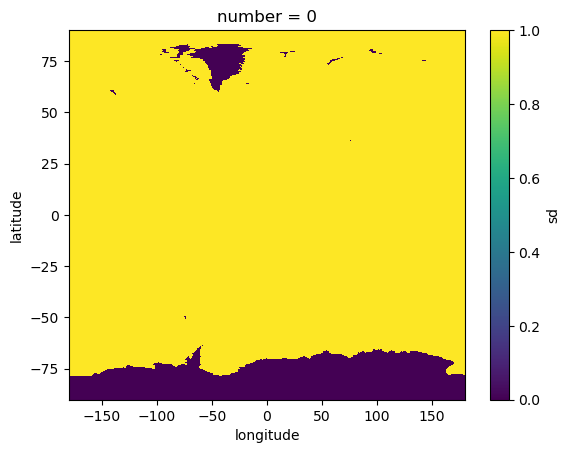

In [54]:
sd_mask.plot()

#### Low vegetation

In [55]:
cvl = static['cvl']
# Set values equal to 0 as 1, and the rest as 0
cvl_mask = 1 - (cvl == 0).astype(int)

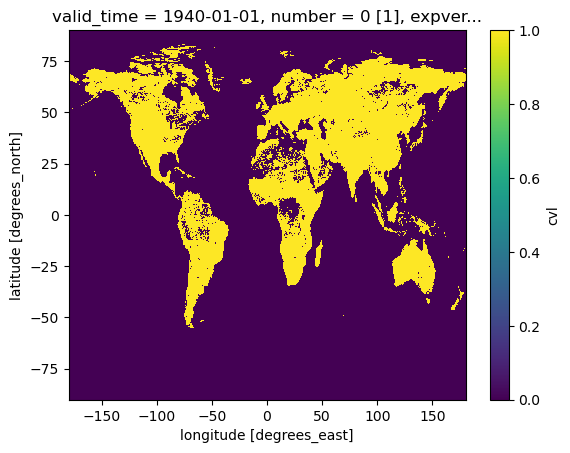

In [56]:
cvl_mask.plot()

#### High vegetation

In [57]:
cvh = static['cvh']
# Set values equal to 0 as 1, and the rest as 0
cvh_mask = 1 - (cvh == 0).astype(int)

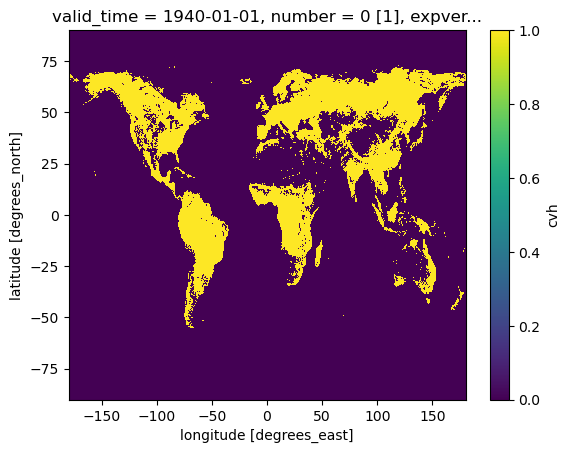

In [58]:
cvh_mask.plot()

#### Land-sea mask

In [59]:
lms = static['lsm']
lms_mask = 1 - xr.where(lms < 0.5, 1, 0)

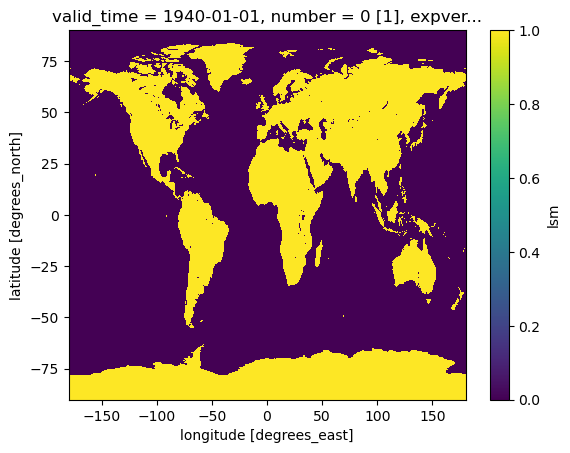

In [60]:
lms_mask.plot()

#### Rainfall

In [70]:
pr_mean = pr['pr'].mean(dim = 'time')
pr_mask = 1 - xr.where(pr_mean<0.3, 1, 0)

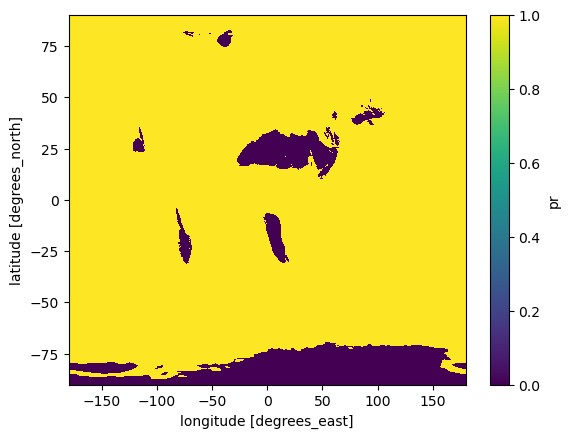

In [71]:
pr_mask.plot()

#### Barrean mask

In [72]:
barrean_mask = lms_mask*sd_mask*(cvl_mask+cvh_mask)*pr_mask.values

In [73]:
barrean_mask = xr.where(barrean_mask>=1, 1, 0)

In [74]:
barrean_mask['longitude'] = pr_mask.lon.values
barrean_mask['latitude'] = pr_mask.lat.values

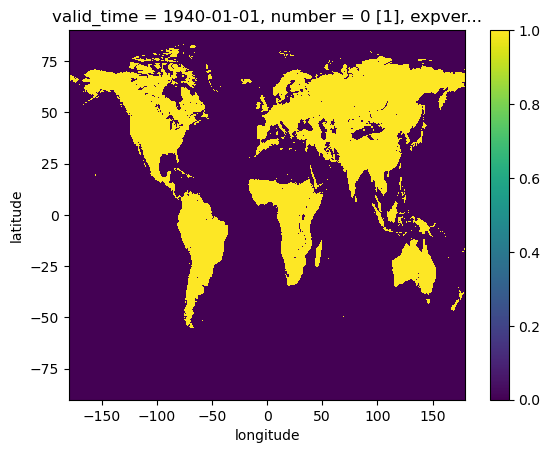

In [75]:
barrean_mask.plot()

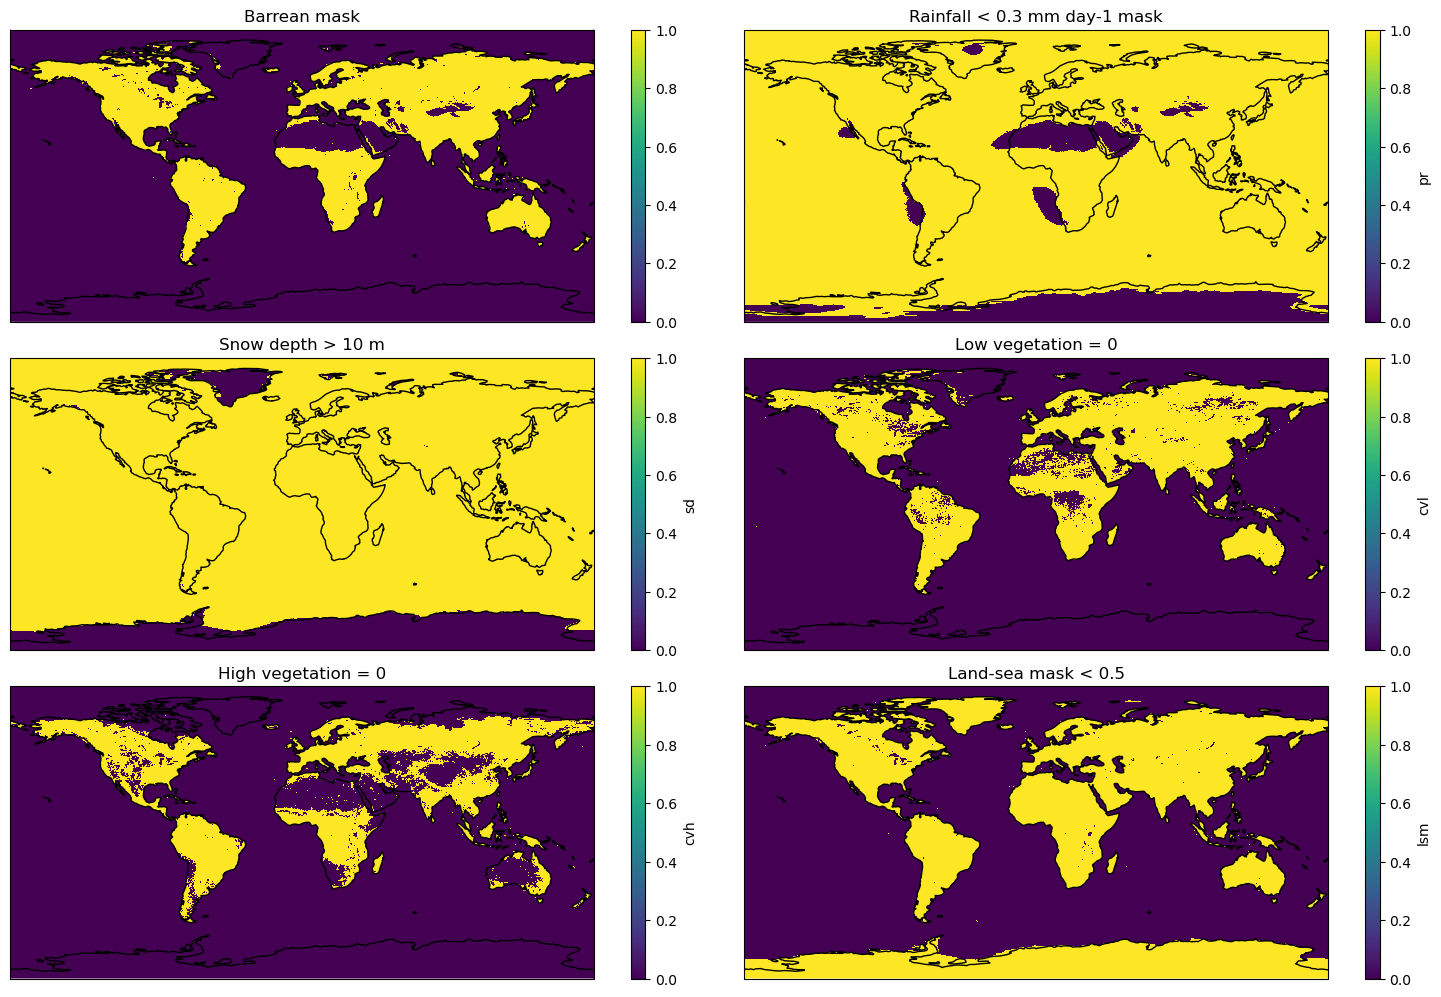

In [76]:
# Create a 3x3 subplot figure
fig, axes = plt.subplots(3, 2, figsize=(15, 10), subplot_kw={"projection": ccrs.PlateCarree()})

# barrean mask 
barrean_mask.plot(ax = axes[0, 0], transform=ccrs.PlateCarree())
axes[0, 0].coastlines()  # Add coastlines
axes[0, 0].set_title(f"Barrean mask")

# pr mask 
pr_mask.plot(ax = axes[0, 1], transform=ccrs.PlateCarree())
axes[0, 1].coastlines()  # Add coastlines
axes[0, 1].set_title(f"Rainfall < 0.3 mm day-1 mask")

# Snow depth 
sd_mask.plot(ax = axes[1, 0], transform=ccrs.PlateCarree())
axes[1, 0].coastlines()  # Add coastlines
axes[1, 0].set_title(f"Snow depth > 10 m")

# Low vegetation 
cvl_mask.plot(ax = axes[1, 1], transform=ccrs.PlateCarree())
axes[1, 1].coastlines()  # Add coastlines
axes[1, 1].set_title(f"Low vegetation = 0")

# High vegetation 
cvh_mask.plot(ax = axes[2, 0], transform=ccrs.PlateCarree())
axes[2, 0].coastlines()  # Add coastlines
axes[2, 0].set_title(f"High vegetation = 0")

# Land-sea mask 
lms_mask.plot(ax = axes[2, 1], transform=ccrs.PlateCarree())
axes[2, 1].coastlines()  # Add coastlines
axes[2, 1].set_title(f"Land-sea mask < 0.5")

# Adjust layout
plt.tight_layout()

fig.savefig('barrean_mask.png', format='png', bbox_inches='tight')

In [77]:
ds_barrean = barrean_mask.to_dataset(name="barrean")

In [80]:
ds_barrean = ds_barrean.drop_vars(["valid_time", "number", "expver"])

In [81]:
ds_barrean = ds_barrean.rename({"longitude": "lon", "latitude": "lat"})

In [82]:
ds_barrean['barrean'].attrs["longname"] = "Barrean mask"
ds_barrean['barrean'].attrs["comment"] = "The Barrean mask has been generated using ERA5 data based on the following criteria: 1) Any pixel with less than 50% land (lsm<0.5), 2) no high or low vegetation (tvl = 0, tvh = 0), 3) snow depth larger than or equal to 10m (sd>10) and 4) annual mean precipitation lower than 0.3 mm day-1"

In [ ]:
#ds_barrean['barrean'].to_netcdf('barrean_mask_ERA5.nc')

## Interpolate mask for the rest of the datasets

In [ ]:
path = "./data/ERA5-Land/"
ERA5_Land = xr.open_dataset(path + 't_ERA5-Land_mon_195001-202212.nc')
path = './data/CERRA/'
CERRA = xr.open_dataset(path + 'pr_gr006_mon_CERRA_day_198409_198412.nc')
path = './data/CPC/'
CPC = xr.open_dataset(path + 'pr_raw_mon_CPC_day_197901_197912.nc')

In [12]:
mesh_grids = {
    'CMIP6': {'lon': np.arange(-179.5, 179.5 + 1 , 1),
              'lat': np.arange(-89.5, 89.5 + 1, 1)},
    'CMIP5': {'lon': np.arange(-179.0, 179.0 + 2, 2),
              'lat': np.arange(-89, 89.0 +2 , 2)},
    'CORDEX-EUR-11': {'lon': np.arange(-44.8125, 65.1875 + 0.125, 0.125),
                      'lat': np.arange(21.8125, 72.6875 + 0.125, 0.125)},
    'CORDEX-CORE': {'lon': np.arange(-179.875, 179.875 + 0.25, 0.25),
                    'lat': np.arange(-89.875, 89.875 + 0.25, 0.25)}, 
    'E-OBS': {'lon': np.arange(-24.9375, 45.4375 + 0.125, 0.125),
             'lat': np.arange(25.0625, 71.4375 + 0.125, 0.125)},
    'ERA5-Land': {'lon': ERA5_Land.lon.values,
                  'lat': ERA5_Land.lat.values},
    'CERRA': {'lon': CERRA.lon.values,
              'lat': CERRA.lat.values},
    'CPC': {'lon': CPC.lon.values,
            'lat': CPC.lat.values},
}

In [13]:
ds = xr.open_dataset("barrean_mask_ERA5.nc")

In [14]:
for dataset in mesh_grids:
    new_lon = mesh_grids[dataset]['lon']
    new_lat = mesh_grids[dataset]['lat']
    ds_interp = ds.interp(lat=new_lat, lon=new_lon, method='nearest')
    ds_interp.to_netcdf(f"barrean_mask_{dataset}.nc")

In [78]:
ds = xr.open_dataset("barrean_mask_CERRA.nc")